In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from statsmodels import robust
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
import math
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from prettytable import PrettyTable 

In [2]:
# We defined a function called Prediction which would take a txt file as input.
# This txt file would contain data in the form of what was collected from Zomato
# We added the feature engineered features using dictionaries which we saved as pickle files.
# We would preprocess the Input file and encode the categorical features using the saved OneHotEncoders as pickle files.
# The numerical features were normalized using the saved pickle weights as well.
# After converting the Input data, it was passed through the Best_model which was saved after training.
# Using the Best Model, we are able to predict the rating for the given Input file.
# We return the Prediction and actual rating of the restaurant.

def Prediction(Input):
    df = pd.read_csv(Input,sep=";")
    
    user_review=[]
    df.review = df.review.replace(np.nan,0)
    if df['review'].values==0:
        user_review = 0
        avg_user_rating = 0
        user_votes = 0
    else:
        for j in df['review'][0].split("'"): 
            if j[0:5]=='Rated':
                user_review.append(float(j[6:9]))
        avg_user_rating = (round(np.mean(user_review),2))
        user_votes = len(user_review)
    df['user_votes'] = user_votes
    #print(user_review,avg_user_rating,user_votes)
    
    
    total_cuisines = len(df['cuisines'][0].split(","))
    df['total_cuisines'] = total_cuisines
    #print(df['cuisines'][0].split(","),total_cuisines)
    
    
    c = len(df['rest_type'][0].split(","))
    if c>=2:
        multitype_restaurant = "Yes"
    else:
        multitype_restaurant = "No"
    df['multitype_restaurant'] = multitype_restaurant
    #print(df['rest_type'][0],multitype_restaurant)
    
    
     #we observed that some of the values had a ',' in between them (1,200), we replace it.
    if type(df['approx_cost(for two people)'][0]) == str:
        df['approx_cost(for two people)'] = int(df['approx_cost(for two people)'][0].replace(',',''))
    else:
        df['approx_cost(for two people)'] = int(df['approx_cost(for two people)'].replace(',',''))
    RevPASH = (df['approx_cost(for two people)'][0]*user_votes)/100
    df['RevPASH'] = RevPASH
    #print(RevPASH)
    
    
    population  = pd.read_csv('population_data.csv',encoding='latin-1')
    l=[]
    for a,b,c,d,e,f in zip(population['Total Population'].values,population['Female Population '].values,
                       population['Male Population '].values,population['Grocery Concentration'].values,
                       population['Resturant Concentration'].values,population['Cafe Concentration'].values):
        l.append([a,b,c,d,e,f])
    
    loc = list(population.Location.values)
    d = dict(zip(loc,l))
    Total_P = (d[df['location'][0]][0])
    df['Total_p'] = Total_P
    Female_P = (d[df['location'][0]][1])
    df['Female_p'] = Female_P
    Male_P = (d[df['location'][0]][2])
    df['Male_p'] = Male_P
    Grocery_conc = (d[df['location'][0]][3])
    df['Grocery_conc'] = Grocery_conc
    Restaurant_conc = (d[df['location'][0]][4])
    df['Restaurant_conc'] = Restaurant_conc
    Cafe_conc = (d[df['location'][0]][5])
    df['Cafe_conc'] = Cafe_conc
    #print(Total_P,Female_P,Male_P,Grocery_conc,Restaurant_conc,Cafe_conc)
    
    
    name = df['name'][0].lower() #converting thwm to lower case
    name = name.replace(' ','_') #replacing space between words with _
    name = name.replace('-','_') #replacing - with _
    name = name.replace(':','_') # replacing : with _
    name = name.replace('&','and') #replacing & with 'and'
    name = name.replace("'",'')
    name = re.sub('[^A-Za-z0-9]+', '_', name) #removing special characters
    
    
    with open('location.pkl', 'rb') as f:
        loc = pickle.load(f)
    loc_lg = loc[df['location'][0]]
    df['loc_lg'] = loc_lg
    #print(loc_lg)
    with open('rest_type.pkl', 'rb') as f:
        rt = pickle.load(f)
    rest_lg = rt[df['rest_type'][0]]
    df['rest_lg'] = rest_lg
    #print(rest_lg)
    with open('cuisines.pkl', 'rb') as f:
        cuisines = pickle.load(f)
    cuisines_lg = cuisines[df['cuisines'][0]]
    df['cuisines_lg'] = cuisines_lg
    #print(cuisines_lg)
    with open('name.pkl', 'rb') as f:
        names = pickle.load(f)
    name_lg = names[name]
    df['name_lg'] = name_lg
    #print(name_lg)
    with open('listed_in(type).pkl', 'rb') as f:
        listed = pickle.load(f)
    listed_lg = listed[df['listed_in(type)'][0]]
    df['listed_lg'] = listed_lg
    #print(listed_lg)
    
    
    
    with open('order', 'rb') as f:
        order = pickle.load(f)
    X_order = order.transform(df['online_order'].values.reshape(-1, 1))
    #print(X_order)
    with open('table', 'rb') as f:
        table = pickle.load(f)
    X_table = table.transform(df['book_table'].values.reshape(-1, 1))
    #print(X_table)
    with open('multitype', 'rb') as f:
        multitype = pickle.load(f)
    X_multitype = multitype.transform(df['multitype_restaurant'].values.reshape(-1, 1))
    #print(X_multitype)
    with open('rest_type', 'rb') as f:
        rest_type = pickle.load(f)
    X_rest_type = rest_type.transform(df['rest_type'].values.reshape(-1, 1))
    #print(X_rest_type)
    with open('listed_in', 'rb') as f:
        listed_in = pickle.load(f)
    X_listed_in = listed_in.transform(df['listed_in(type)'].values.reshape(-1, 1))
    #print(X_listed_in)
    with open('city', 'rb') as f:
        city = pickle.load(f)
    X_city = city.transform(df['listed_in(city)'].values.reshape(-1, 1))
    #print(X_city)
    
    
    with open('votes', 'rb') as f:
        votes = pickle.load(f)
    X_votes = votes.transform(df['votes'].values.reshape(-1, 1))
    #print(X_votes)
    with open('user_votes', 'rb') as f:
        user_vote = pickle.load(f)
    X_user_vote = user_vote.transform(df['user_votes'].values.reshape(-1, 1))
    #print(X_user_vote)
    with open('cost', 'rb') as f:
        cost = pickle.load(f)
    X_cost = cost.transform(df['approx_cost(for two people)'].values.reshape(-1, 1))
    #print(X_cost)
    with open('tc', 'rb') as f:
        tc = pickle.load(f)
    X_tc = tc.transform(df['total_cuisines'].values.reshape(-1, 1))
    #print(X_tc)
    with open('rp', 'rb') as f:
        rp = pickle.load(f)
    X_rp = rp.transform(df['RevPASH'].values.reshape(-1, 1))
    #print(X_rp)
    with open('tp', 'rb') as f:
        tp = pickle.load(f)
    X_tp = tp.transform(df['Total_p'].values.reshape(-1, 1))
    #print(X_tp)
    with open('fp', 'rb') as f:
        fp = pickle.load(f)
    X_fp = fp.transform(df['Female_p'].values.reshape(-1, 1))
    #print(X_fp)
    with open('mp', 'rb') as f:
        mp = pickle.load(f)
    X_mp = mp.transform(df['Male_p'].values.reshape(-1, 1))
    #print(X_mp)
    with open('gc', 'rb') as f:
        gc = pickle.load(f)
    X_gc = gc.transform(df['Grocery_conc'].values.reshape(-1, 1))
    #print(X_gc)
    with open('rc', 'rb') as f:
        rc = pickle.load(f)
    X_rc = rc.transform(df['Restaurant_conc'].values.reshape(-1, 1))
    #print(X_rc)
    with open('cc', 'rb') as f:
        cc = pickle.load(f)
    X_cc = cc.transform(df['Cafe_conc'].values.reshape(-1, 1))
    #print(X_cc)
    with open('ll', 'rb') as f:
        ll = pickle.load(f)
    X_ll = ll.transform(df['loc_lg'].values.reshape(-1, 1))
    #print(X_ll)
    with open('rl', 'rb') as f:
        rl = pickle.load(f)
    X_rl = rl.transform(df['rest_lg'].values.reshape(-1, 1))
    #print(X_rl)
    with open('cl', 'rb') as f:
        cl = pickle.load(f)
    X_cl = cl.transform(df['cuisines_lg'].values.reshape(-1, 1))
    #print(X_cl)
    with open('nl', 'rb') as f:
        nl = pickle.load(f)
    X_nl = nl.transform(df['name_lg'].values.reshape(-1, 1))
    #print(X_nl)
    with open('ln', 'rb') as f:
        ln = pickle.load(f)
    X_ln = ln.transform(df['listed_lg'].values.reshape(-1, 1))
    #print(X_ln)
    
    
    X_test = hstack((X_order,X_table,X_multitype,X_rest_type,X_listed_in,X_city,X_votes,X_user_vote,X_cost,X_tc,X_rp,
                    X_tp,X_fp,X_mp,X_gc,X_rc,X_cc,X_ll,X_rl,X_cl,X_nl,X_ln)).tocsr()
    X_point = pd.DataFrame(X_test.toarray())
    #print(X_point)
    
    with open('Best_Model', 'rb') as f:
        Best_Model = pickle.load(f)
    Pred= Best_Model.predict(X_point)
    #print(Pred)
    return Pred, avg_user_rating

In [3]:
# We define a function performance metric to calculate the R2 and RMSE score for given Input file.
# We call the Prediction function defined earlier and use the predicted and actual rating to calculate R2 and RMSE score.
# We print R2 and RMSE score


def performance_metrics(Input):
    pred = Prediction(Input)
    rmse = abs(pred[0]-pred[1])
    if pred[0]>pred[1]:
        r2 = pred[1]/pred[0]
    else:
        r2 = pred[0]/pred[1]
    print("Performance Metrics for the Input Data are:")
    print("The RMSE Score = {}".format(rmse))
    print("The R2 Score = {}".format(r2))

In [4]:
Pred = Prediction('Test_1.txt')
print("The Predicted Rating for the given Input data is {}".format(Pred[0]))
performance_metrics('Test_1.txt')

The Predicted Rating for the given Input data is [3.96339236]
Performance Metrics for the Input Data are:
The RMSE Score = [0.03660764]
The R2 Score = [0.99084809]


In [5]:
Pred = Prediction('Test_2.txt')
print("The Predicted Rating for the given Input data is {}".format(Pred[0]))
performance_metrics('Test_2.txt')

The Predicted Rating for the given Input data is [4.52459738]
Performance Metrics for the Input Data are:
The RMSE Score = [4.52459738]
The R2 Score = [0.]


In [6]:
Pred = Prediction('Test_3.txt')
print("The Predicted Rating for the given Input data is {}".format(Pred[0]))
performance_metrics('Test_3.txt')

The Predicted Rating for the given Input data is [3.86992313]
Performance Metrics for the Input Data are:
The RMSE Score = [0.06992313]
The R2 Score = [0.98193165]


In [7]:
x = PrettyTable()
x.field_names = ["Input","Actual_Rating","Predicted_Rating","RMSE_Score","R2_Score"]
x.add_row(["1.","4.0","4.22","0.225","0.9465"])
x.add_row(["2.","0","4.14","4.149","0"])
x.add_row(["3.","3.8","3.76","0.043","0.9885"])
print(x)

+-------+---------------+------------------+------------+----------+
| Input | Actual_Rating | Predicted_Rating | RMSE_Score | R2_Score |
+-------+---------------+------------------+------------+----------+
|   1.  |      4.0      |       4.22       |   0.225    |  0.9465  |
|   2.  |       0       |       4.14       |   4.149    |    0     |
|   3.  |      3.8      |       3.76       |   0.043    |  0.9885  |
+-------+---------------+------------------+------------+----------+


### -  Deployment Using Flask API

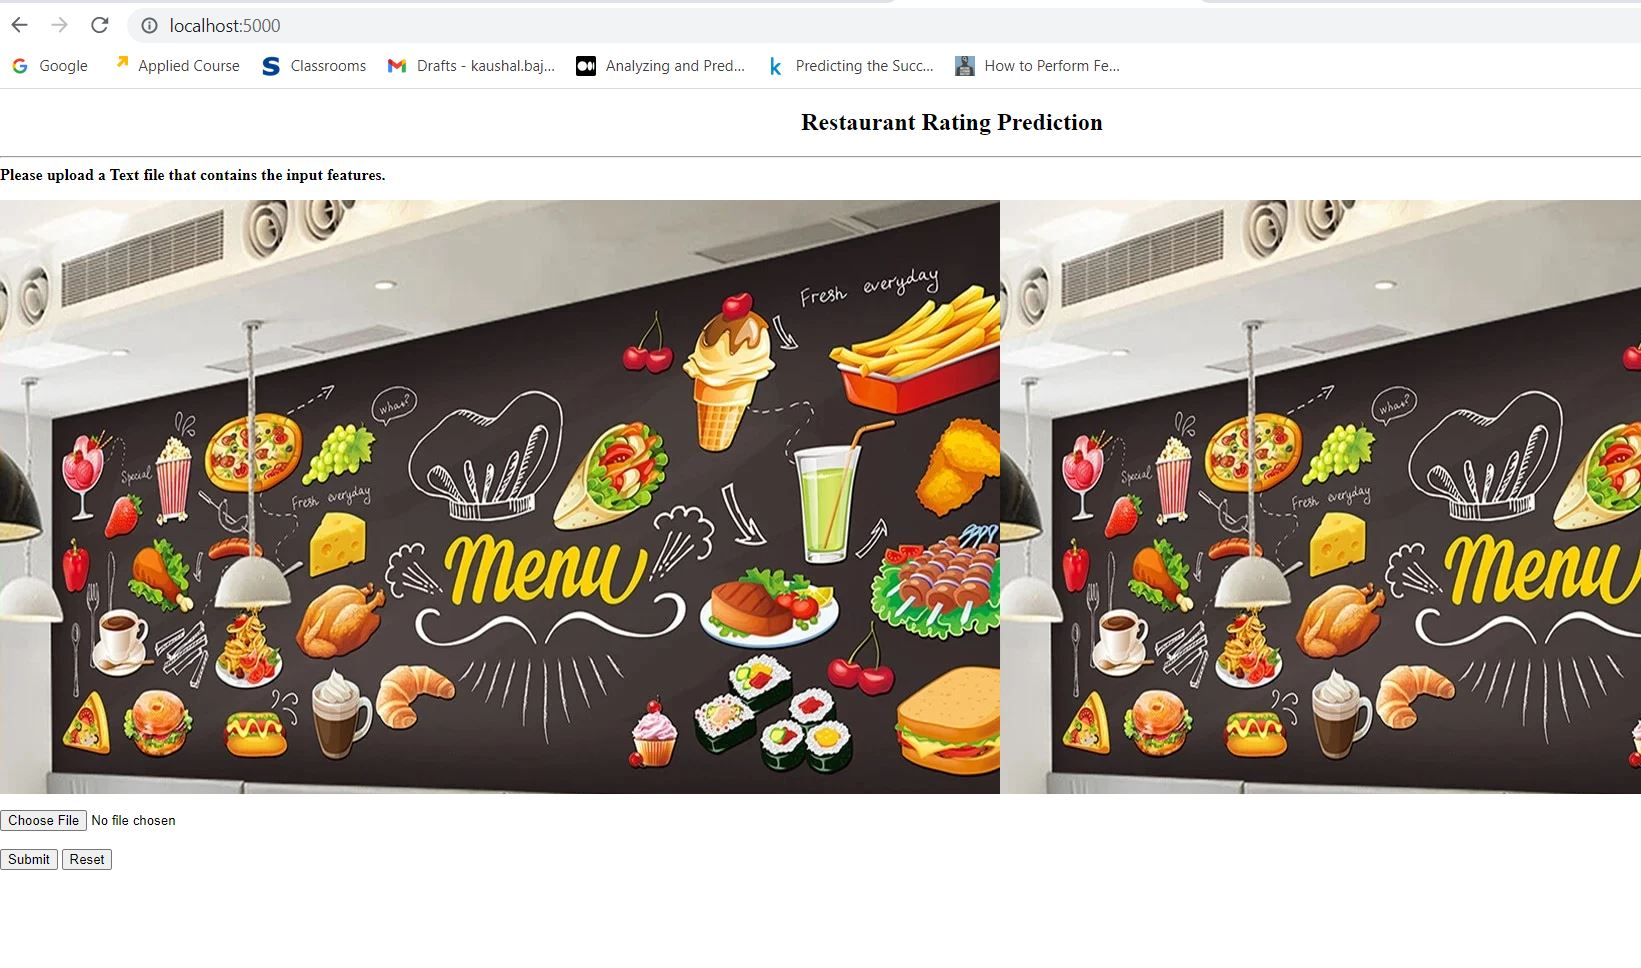

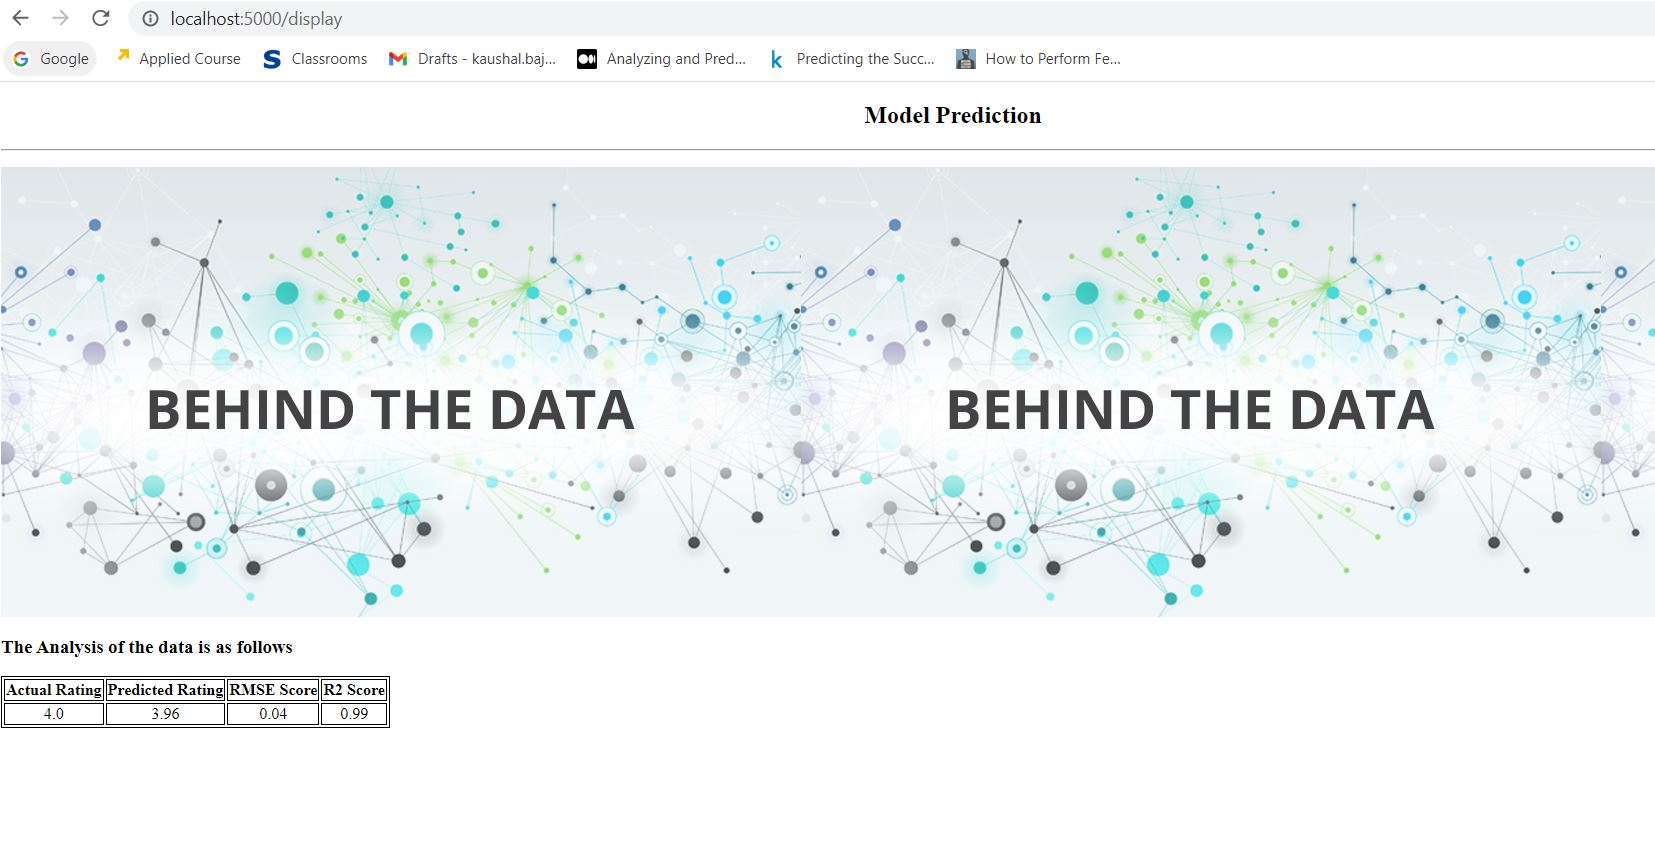

-  We gave Test1.txt as Input in the above FLask API deployment in our local system, we were able to achieve the same result as here.

### Analysis:

-  We made 2 functions, **Prediction** and **Performance_Metric** to evalute the Data points.
-  We ran this prediction model for 3 randomly selected data points from our dataset.
-  For the **1st** point we were able to produce a rating of **4.22** with an **RMSE** score of **0.225** and **R2** score of **0.9465**, which shows that the prediction was quite close to the actual rating and therefore, the model performance was good.
-  The **2nd** point did not have a rating **(Maybe a new restaurant)**, Our model was able to predict the rating for such an restaurant as well. It had a **Predicted** rating of **4.14**
-  The **3rd** point we were able to produce a rating of **3.76** with an **RMSE** score of **0.043** and **R2** score of **0.9885**, which is even better than the **1st** point.
-  We were able to deploy the same model using **Flask API** in our **Local System** as well as **AWS**. We have added the screenshot for the **HTML** pages. The recorded video of the same is as follows - https://drive.google.com/file/d/1D3cHAMYEBxqPUaDZfElrHwd-LIg27Zni/view?usp=sharing